# Molecular Dynamics Simulation with Step by Step Guide

In this notebook I will show a set by step guide on how you can build you own cool molecular dynaamics simulation 
1. The notebook calls the functions listed in the MD_functions.py file
2. The github page on the MD simulation explains in detail how each step adds up ...
3. Just put everything 

In [1]:
# import the standard modules
import scipy as s
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
import time
import numba
from numba import jit
import re
import math
from tqdm import tqdm_notebook

In [6]:
# Write down all the modules that you will need to compute 
@jit(nopython = True)
def LJ_real(sigma, epsi, r):
    Energy = 4*epsi*((sigma/r)**12-(sigma/r)**6);
    return Energy;
    
# Defining function to calculate the d(U)/dr * r
@jit(nopython = True)
def Dudr(sigma, epsi, r):
    Energy = -24*(epsi)*(2*(sigma/r)**12-(sigma/r)**6); # Calculation of the force // calculates fi*ri 
    return Energy;    

# function to perform the averages
@jit(nopython = True)
def averages(A):
    
    sum = 0;
    for i in range(len(A)):
        sum = sum +A[i-1];
    return (sum/len(A));     

# to define the writing file remember to tranpose my array before using this function.
def write_xyz_traj(r, Npart, file_name):
	'''
		This function appends a frame to the end of a xyz file. 
		
		: r : 			position of the particles in the form of [[x1,y1,z1],[x2,y2,z2] ... [xN,yN,zN]]
		: Npart :		number of particles (int)
		: filename :	name of the trajectory file where the frame gets appended (str)

	'''
	output_box0 = open(file_name + '.xyz', 'a')
	output_box0.write('%0.0i\n\n' % Npart)
	[output_box0.write('%s\t%0.5f\t%0.5f\t%0.5f\n' % ("C", r[i, 0], r[i, 1], r[i, 2])) for i in range(0, Npart)]
	output_box0.close() 

# read the trajectory files in XY format     
def read_xyz_trj(file_name):

    xyz_file = open(file_name, 'r')

    frame = 0
    xyz = {}
    READING=True
    while READING:
        try:
            nparts = int(xyz_file.readline())
            xyz_file.readline()
            xyz[frame] = np.zeros([nparts, 3])
            for k in range(0, nparts):
                line = xyz_file.readline()
                line = line.split()
                xyz[frame][k, 0] = line[1]
                xyz[frame][k, 1] = line[2]
                xyz[frame][k, 2] = line[3]
            frame += 1
        except:
            print("Reach end of '" + file_name + "'")
            READING=False

    return xyz

# check the log if it is correctly coming
def verifylog(filename):

    '''
    To read the KE, PE and all the other stuff in the lammps log file.
    '''
    inp_dat = open(filename,"r");

    count  = 0;
    coord_arr = [[],[],[],[],[],[]]; # Mega Array to Store all the Stuff.


    for line in inp_dat: 
    
        temp = line.split(); # to Segregate the coordinartes
        x = float(temp[0]);
        coord_arr[0].append(x);
        y = float(temp[1])
        coord_arr[1].append(y);
        z = float(temp[2]);
        coord_arr[2].append(z);
        a = float(temp[3]);
        coord_arr[3].append(a);
        b = float(temp[4]);
        coord_arr[4].append(b);  
        c = float(temp[5]);
        coord_arr[5].append(c);     # to Skip the first two lines as they dont have the trajectories.  
    
    return coord_arr 
    
# write the frame out into a lammps
def write_frame(coords, L, vels, forces, trajectory_name, step):
    '''
    function to write trajectory file in LAMMPS format

    output can be read in in VMD using the provided vis.vmd script using
    vmd -e vis.vmd
    You may need to adjust name of trajectory file in vis.vmd

    In VMD you can visualize the motion of particles.


    :param coords: coordinates
    :param vels: velocities
    :param forces: forces
    :param trajectory_name: trajectory filename

    :return:
    '''

    nPart = len(coords[:, 0])
    nDim = len(coords[0, :])
    with open(trajectory_name, 'a') as file:
        file.write('ITEM: TIMESTEP\n')
        file.write('%i\n' % step)
        file.write('ITEM: NUMBER OF ATOMS\n')
        file.write('%i\n' % nPart)
        file.write('ITEM: BOX BOUNDS pp pp pp\n')
        for dim in range(nDim):
            file.write('%.6f %.6f\n' % (-0.5 * L[dim], 0.5 * L[dim]))
        for dim in range(3 - nDim):
            file.write('%.6f %.6f\n' % (0, 0))
        file.write('ITEM: ATOMS id type xu yu zu vx vy vz fx fy fz\n')

        temp = np.zeros((nPart, 9))
        for dim in range(nDim):
            temp[:, dim] = coords[:, dim]
            temp[:, dim + 3] = vels[:, dim]
            temp[:, dim + 6] = forces[:, dim]

        for part in range(nPart):
            file.write('%i %i %.4f %.4f %.4f %.6f %.6f %.6f %.4f %.4f %.4f\n' % (part + 1, 1, *temp[part, :]))

# write down the trajectory in .xyz format
def write_xyz_traj(r, Npart, file_name):
	'''
		This function appends a frame to the end of a xyz file. 
		
		: r : 			position of the particles in the form of [[x1,y1,z1],[x2,y2,z2] ... [xN,yN,zN]]
		: Npart :		number of particles (int)
		: filename :	name of the trajectory file where the frame gets appended (str)

	'''
	output_box0 = open(file_name + '.xyz', 'a')
	output_box0.write('%0.0i\n\n' % Npart)
	[output_box0.write('%s\t%0.5f\t%0.5f\t%0.5f\n' % ("C", r[i, 0], r[i, 1], r[i, 2])) for i in range(0, Npart)]
	output_box0.close()
     
# Function to compute the radial distribution function 
def rdf(xyz, LxLyLz, n_bins=100, r_range=(0.01, 10.0)):
    '''
    rarial pair distribution function

    :param xyz: coordinates in xyz format per frame
    :param LxLyLz: box length in vector format
    :param n_bins: number of bins
    :param r_range: range on which to compute rdf
    :return:
    '''

    g_r, edges = np.histogram([0], bins=n_bins, range=r_range)
    g_r[0] = 0
    g_r = g_r.astype(np.float64)
    rho = 0

    for i, xyz_i in enumerate(xyz):
        xyz_j = np.vstack([xyz[:i], xyz[i + 1:]])
        d = np.abs(xyz_i - xyz_j)
        d = np.where(d > 0.5 * LxLyLz, LxLyLz - d, d)
        d = np.sqrt(np.sum(d ** 2, axis=-1))
        temp_g_r, _ = np.histogram(d, bins=n_bins, range=r_range)
        g_r += temp_g_r

    rho += (i + 1) / np.prod(LxLyLz)
    r = 0.5 * (edges[1:] + edges[:-1])
    V = 4./3. * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
    norm = rho * i
    g_r /= norm * V

    return r, g_r

# To read the LAMMPS trajectory files
def read_lammps_trj(lammps_trj_file):

    def read_lammps_frame(trj):
        """Load a frame from a LAMMPS dump file.

        Args:
            trj (file): LAMMPS dump file of format 'ID type x y z' or
                                                   'ID type x y z vx vy vz' or
                                                   'ID type x y z fz'
            read_velocities (bool): if True, reads velocity data from file
            read_zforces (bool): if True, reads zforces data from file

        Returns:
            xyz (numpy.ndarray):
            types (numpy.ndarray):
            step (int):
            box (groupy Box object):
            vxyz (numpy.ndarray):
            fz (numpy.ndarray):
        """
        # --- begin header ---
        trj.readline()  # text "ITEM: TIMESTEP"
        step = int(trj.readline())  # timestep
        trj.readline()  # text "ITEM: NUMBER OF ATOMS"
        n_atoms = int(trj.readline())  # num atoms
        trj.readline()  # text "ITEM: BOX BOUNDS pp pp pp"
        Lx = trj.readline().split()  # x-dim of box
        Ly = trj.readline().split()  # y-dim of box
        Lz = trj.readline().split()  # z-dim of box
        L = np.array([float(Lx[1]) - float(Lx[0]),
                      float(Ly[1]) - float(Ly[0]),
                      float(Lz[1]) - float(Lz[0])])
        trj.readline()  # text
        # --- end header ---

        xyz = np.empty(shape=(n_atoms, 3))
        xyz[:] = np.NAN
        types = np.empty(shape=(n_atoms), dtype='int')
        vxyz = np.empty(shape=(n_atoms, 3))
        vxyz[:] = np.NAN
        fxyz = np.empty(shape=(n_atoms, 3))
        fxyz[:] = np.NAN

        # --- begin body ---

        IDs = []
        for i in range(n_atoms):
            temp = trj.readline().split()
            a_ID = int(temp[0]) - 0  # atom ID
            xyz[a_ID - 1] = [float(x) for x in temp[2:5]]  # coordinates
            types[a_ID - 1] = int(temp[1])  # atom type
            vxyz[a_ID - 1] = [float(x) for x in temp[5:8]]  # velocities
            fxyz[a_ID - 1] = [float(x) for x in temp[8:11]]  # map(float, temp[5]) # z-forces

        # --- end body ---
        return xyz, types, step, L, vxyz, fxyz


    xyz = {}
    vel = {}
    forces = {}
    with open(lammps_trj_file, 'r') as f:
        READING = True
        c = 0
        while READING:
            try:
                xyz[c], _, _, _, vel[c], forces[c] = read_lammps_frame(f)
                c += 1
            except:
                READING=False

    return xyz, vel, forces

# Defining the function for calculation of the total Potential energy
@jit(nopython = True)
def Etot (Natom, sigma, epsi, traj, Rcut, Lx, Ly, Lz): 
    '''
    Calculates the total energy of a frame. function nameis kept different from the one in the assignment (totalEnergy).
    
    param:
    Natom: total atoms
    sigma, eplsilon are written as sigma and epsi 
    traj: particle trajectory for the frame.
    box dimenstions as Lx, Ly and Lz.
    Rcut is cutoff radius
    
    output:
    gives the energy of the system as same units as epslion.
    '''
    
    U_adder = 0;  # to store the Total Energy Computed

 # Now setting up a loop for computing nC2 combinations.

    for i in range(0,Natom-1):  
        
        for j in range(i+1,Natom):
            
    # we store the values of the the trajectores of the two atoms in z=x, y, z so that it is more convinient to write the code
    # although it uses up a lot of the space for the Memory.
                  
            x1 = traj[0][i];
            y1 = traj[1][i];
            z1 = traj[2][i];
            
     # Similarly we put for atom 2
            
            x2 = traj[0][j];
            y2 = traj[1][j];
            z2 = traj[2][j];  
            
  # Getting done with the PBC Stuff

            tr2 = np.array([x2, y2, z2]);
            tr1 = np.array([x1, y1, z1]);
            dist = np.abs(tr2 - tr1);
            lxlylz = np.array([Lx, Ly, Lz]);
            dist = np.where(dist > 0.5 * lxlylz, lxlylz - dist, dist);
        
    # now we calculate the Distance between the two particles
            
            R = (dist[0]**2 + dist[1]**2 + dist[2]**2)**0.5;
            
    #  Apply the Cutoff Radius Method  and shift the energy potentials properly so that they are no discontinuous.  
        
            if (R <= Rcut):
                
                U_adder = U_adder + LJ_real(sigma,epsi,R) ;  # Tail correction factor is an approximation

        U_adder = U_adder + (Natom/(Lx*Ly*Lz))*8/3*np.pi*epsi*(sigma**3)*(1/3*(sigma/Rcut)**9 - (sigma/Rcut)**3);
    return U_adder;

# Define a function that creates the first frames for the simulation 
def initGrid( Natom, Lx, Ly, Lz):
    '''
    the rows are the xyz coordinates and the columns are the atoms. To bring to the standard format 
    with xyz in columns and atoms in rows please use .transpose() after the array variable. eg: a.transpose(); 
    '''
    a = Lx*Ly*Lz/Natom;
    cell_length = a**(1/3);
  
    px = round(Lx/cell_length);
    py = round(Ly/cell_length);
    
    cell_length = Lx/(px+1); 
    
    # to ensure that atleast (sigma) distance is maintained between atoms
    if (py >= 9):
        py = py-1; 
    if (px >= 9):
        px = px-1;
    
    coord_arr = np.zeros((3,Natom))
    count = 0;
    cx = 0;
    cy = 0;
    cz = 0;
    
    while(count<= Natom):
        if (count >= Natom):
            break;
        for i in range(0, py+1):
            
            for j in range(0, px+1): 
                if (count >= Natom):
                    break;
                coord_arr[0][count] =  j*cell_length;
                coord_arr[1][count] =  i*cell_length;
                coord_arr[2][count] =  cz*cell_length;
                count+= 1;
        cz +=1;
    '''
    The coordinates that have been created are from 0 to 30 ang in x,y,z direction.
    now we shift it to half the max distance that an atom is place from the origin along each axis.
    so 0 to 30 angsrom becomes -15  to 15 angstrom  along each axis
    
    '''
    
    translatex = np.max(coord_arr[0])/2;    
    translatey = np.max(coord_arr[1])/2; 
    translatez = np.max(coord_arr[2])/2; 
    coord_arr[0] = coord_arr[0] - (translatex)*np.ones((1, Natom));
    coord_arr[1] = coord_arr[1] - (translatey)*np.ones((1, Natom));
    coord_arr[2] = coord_arr[2] - (translatez)*np.ones((1, Natom));
    return coord_arr

# Assign random speed to the particles in form of maxwell distribution
@jit (nopython =True)
def initvelocity(Natom,R, T, M):
    '''
    Creates random initial velocities
    
    params:
    Natom: Number of Atoms
    T: Temperature in Kelvin
    M: Mass in Gm/mol
    
    Outputs:
    Velocity array in(m/s).
    '''
    sumvx = 0;
    sumvy = 0;
    sumvz = 0;
    
    sumv2x = 0;
    sumv2y = 0;
    sumv2z = 0;
    
    velarr = np.random.rand(3, Natom);
    velarr = velarr - 0.5* np.ones((3, Natom));
    
    for i in range(0, Natom):
        sumvx = sumvx + velarr[0][i];
        sumvy = sumvy + velarr[1][i];
        sumvz = sumvz + velarr[2][i];
        
        sumv2x = sumv2z + (velarr[0][i])**2;
        sumv2y = sumv2z + (velarr[1][i])**2;
        sumv2z = sumv2z + (velarr[2][i])**2;
        
    # rescale the velocities
    scalex = np.sqrt(R*T/(sumv2x)*(Natom*1000)/M);
    scaley = np.sqrt(R*T/(sumv2y)*(Natom*1000)/M)
    scalez = np.sqrt(R*T/(sumv2z)*(Natom*1000)/M)
    
    for i in range(0, Natom):
        
        velarr[0][i] = scalex*(velarr[0][i] - sumvx/Natom);  
        velarr[1][i] = scaley*(velarr[1][i] - sumvy/Natom);
        velarr[2][i] = scalez*(velarr[2][i] - sumvz/Natom);
        
    return velarr

# compute the forces from the hamiltonian @jit(nopython = True)
def forces1(Natom, sigma, epsi,Traj,Lx, Ly, Lz, Rcut,M, T): #  Calculates -Du/Dr
    
    '''
    param:
    Natom number of atoms
    sigma 3.73
    epsi in Kelvin
    Traj : traj for which the force should be calculated; use my previous format (rows as xyz and columns as particle);
    Lx, Ly, Lz in angstrom
    mass in gm /mol
    Rcut is cutoff radius
    T: temperature in Kelvin 
    
    Output:
    Prssure of the frame (in Pascals)
    Acceleration array (in SI units).
    
    '''
    U_adder = 0;
    traj = Traj;
    ff = np.zeros((3,Natom));
    
    for i in range(0, Natom-1):
        for j in range(i+1,Natom):
                       
            x1 = traj[0][i];
            y1 = traj[1][i];
            z1 = traj[2][i];
            
     # Similarly we put for atom 2
            
            x2 = traj[0][j];
            y2 = traj[1][j];
            z2 = traj[2][j];
            
   # Getting done with the PBC Stuff

            x = (x2 - x1) - Lx*np.round((x2 - x1)/Lx);   # for dx = dx - nearest_int(dx/L)
            y = (y2 - y1) - Ly*np.round((y2 - y1)/Ly);
            z = (z2 - z1) - Lz*np.round((z2 - z1)/Lz); 
            
    # now we calculate the Distance between the two particles 

    
    
            r = np.sqrt(x**2 + y**2 + z**2);    
            if ( r <= Rcut):
                
             
                ftot = (24/r**2)*epsi*(sigma/r)**6*(2*(sigma/r)**6-1);  #-dU/Dr

                # Update the force Array
            
                ff[0][i] = ff[0][i] - (x)*(ftot)   # update the reference particle
                ff[1][i] = ff[1][i] - (y)*(ftot)
                ff[2][i] = ff[2][i] - (z)*(ftot)
                
                ff[0][j] = ff[0][j] + (x)*(ftot)   # update the other particle
                ff[1][j] = ff[1][j] + (y)*(ftot)
                ff[2][j] = ff[2][j] + (z)*(ftot)
                
                U_adder = U_adder + Dudr(sigma,epsi,r);
    
    P_reduced = Natom/(Lx*Ly*Lz)*(T)- 1/(3*Lx*Ly*Lz)*((U_adder));  #  1 is taken as epsion is Kelvin and not joules '-' sign is taen cae in the function definition
    P_Pascal = P_reduced*Kb/(10**-30);  
    
    
    ff = ff*Kb/(Ang); # to caulate the force in Newton.
    
    acc = ff*(1000/M*Na); # acc in m/s2
    
    return P_Pascal,  acc;

# compute the kinetic energies of the particles
@jit (nopython = True)
def kinetic(Natom,v):
    '''
    Computes the inetic energy from the velocities of the particles
    
    Params:
    Number of atoms
    velocity array
    
    
    output:
    Temperature in Kelvin
    KE in Joules
    '''
    
    sumvx = 0;
    sumvy = 0;
    sumvz = 0;
    
    sumv2x = 0;
    sumv2y = 0;
    sumv2z = 0;
    
    for i in range(0, Natom):
            sumvx = sumvx + v[0][i];
            sumvy = sumvy + v[1][i];
            sumvz = sumvz + v[2][i];
        
            sumv2x = sumv2z + (v[0][i])**2;
            sumv2y = sumv2z + (v[1][i])**2;
            sumv2z = sumv2z + (v[2][i])**2;
        
    
    T = (16.04*10**-3*(sumv2x+sumv2y+sumv2z)/Natom/(3*R));
    KE = 0.5*(3*Natom+1)* Kb* T;  
    
    return KE, T

# using the velocity verlet algorithm for update the particle positions 
def verlet(Natom, sigma,epsi, M, Lx, Ly, Lz, Rcut, inittraj, initvel, t, steps, T):
    '''
    Performs the verlet integration
    
    param
    Natom: No of atoms
    sigma:sigma
    epsi:epsilon
    M: Mass in gm per mol
    Lx Ly Lz: Box dims
    Rcut: Cutoff
    inittraj: initial trajectory
    initvel: initial velocities
    t: time step size (femto sec for our simulation)
    step: MD ccycle
    T: Temperature
    
    Outputs:
    T, P, (Kelvin and Pascals)
    KE in Joules 
    PE in Kelvin
    '''
    KE = np.zeros((1, steps));
    PE = np.zeros((1, steps));
    T = np.zeros((1, steps));
    P = np.zeros((1, steps));
    trajo = inittraj;
    v = initvel;
    sumvx = 0;
    sumvy = 0;
    sumvz = 0;
    
    sumv2x = 0;
    sumv2y = 0;
    sumv2z = 0;
    
    acc_new = forces1(Natom, sigma, epsi, trajo ,Lx, Ly, Lz, Rcut, M, T);
    

    
    for i in tqdm_notebook(range(0, steps)):
        
        for k in range(0, Natom):
            v[0][k] = v[0][k] + (acc_new[1][0][k])/2*t;
            v[1][k] = v[1][k] + (acc_new[1][1][k])/2*t;
            v[2][k] = v[2][k] + (acc_new[1][2][k])/2*t;
        
        
        for k in range(0, Natom):
            trajo[0][k] = trajo[0][k] + v[0][k]*t*(1e+10);  
            trajo[1][k] = trajo[1][k] + v[1][k]*t*(1e+10); 
            trajo[2][k] = trajo[2][k] + v[2][k]*t*(1e+10); 
         
   
        acc_new = forces1(Natom, sigma, epsi, trajo ,Lx, Ly, Lz, Rcut, M , T);
        

        # Store the pressure
        P[0][i] = (acc_new[0][0][0]);
            
        for k in range(0, Natom):
          
            v[0][k] = v[0][k] + (acc_new[1][0][k])/2*t;
            v[1][k] = v[1][k] + (acc_new[1][1][k])/2*t;
            v[2][k] = v[2][k] + (acc_new[1][2][k])/2*t;
        
        # Put the partices back into the box
        
        for j in range(0, Natom):
            
            if (trajo[0][j] > Lx/2):
                trajo[0][j] = trajo[0][j] - Lx;
                
        
            if (trajo[0][j] < -Lx/2):
                trajo[0][j] = trajo[0][j] + Lx;
                
            if (trajo[1][j] > Ly/2):
                trajo[1][j] = trajo[1][j] - Lx;
            
            if (trajo[1][j] < -Ly/2):
                trajo[1][j] = trajo[1][j] + Lx;
                
            if (trajo[2][j] > Lz/2):
                trajo[2][j] = trajo[2][j] - Lx;   
                
            if (trajo[2][j] < -Lz/2):
                trajo[2][j] = trajo[2][j] + Lx; 
    
        a = kinetic(Natom, v);
        T[0][i]  = a[1];
        KE[0][i] = a[0];
        PE[0][i] = Etot (Natom, sigma, epsi, trajo, Rcut, Lx, Ly, Lz); 
        
        
    return T, P, KE, PE     

# build the Nose`- Hoover Thermostat with the verlet update 
def velocityVerletThermostat(Natom, sigma,epsi, M, Lx, Ly, Lz, Rcut, inittraj, initvel, T, Q, t, steps, freq, filename):
    '''
    velocity verlet + nose hoover thermostat
    
    param:
    
    freq: writing frequency
    filename: writing file name (write a lammps trajectory file)
    
    ouputs:
    Avg_p: average pressure
    Avg_T: average temperature
    pressure array (pascals)
    Kinetic energy array (Joules)
    Potential energy array (Kelvin)

    '''
    #~~~~~~~~~~~~~Some initialisations~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                             
    KE = np.zeros((1, steps));
    PE = np.zeros((1, steps));
    Temperature = np.zeros((1, steps));
    Pressure = np.zeros((1, steps));
                             
    trajo = inittraj;
    v = initvel;  
    KEref  =  0.5*(3*Natom+1)* Kb* T;    
        
    # Calculate the initial damping parameter
    damp = 0;
    a = kinetic(Natom, v);
    damp  = damp + 0.5*t/Q*(a[0] - KEref);
                             
    # initial Forces
    acc_new = forces1(Natom, sigma, epsi, trajo ,Lx, Ly, Lz, Rcut, M, T );
                            
 #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~                            
                             
    for i in range(0, steps):
        
        a = kinetic(Natom, v);
        Temperature[0][i] = a[1];                     
        KE[0][i] = a[0];
        PE[0][i] = Etot (Natom, sigma, epsi, trajo, Rcut, Lx, Ly, Lz);
                        
        
        # update trajectory
        for k in range(0, Natom):
            trajo[0][k] = trajo[0][k] + v[0][k]*t*(1e+10) + (acc_new[1][0][k] - damp*v[0][k])/2*t*t*(1e+10)
            trajo[1][k] = trajo[1][k] + v[1][k]*t*(1e+10) + (acc_new[1][0][k] - damp*v[0][k])/2*t*t*(1e+10)
            trajo[2][k] = trajo[2][k] + v[2][k]*t*(1e+10) + (acc_new[1][0][k] - damp*v[0][k])/2*t*t*(1e+10)
                             
        # damp for half the time step                     
        a = kinetic(Natom, v);                     
        damp  = damp + 0.5*t/Q*(a[0] - KEref);                      
                                     
        # update the velocity with the damp for half the time step (remove the inital damp )                  
        for k in range(0, Natom):
                             
            v[0][k] = v[0][k] + (acc_new[1][0][k] - damp*v[0][k])/2*t;
            v[1][k] = v[1][k] + (acc_new[1][1][k] - damp*v[1][k])/2*t;
            v[2][k] = v[2][k] + (acc_new[1][2][k] - damp*v[2][k])/2*t;
        
       
            
        # Update the forces
        acc_new = forces1(Natom, sigma, epsi, trajo ,Lx, Ly, Lz, Rcut, M, T );
        
        # Store the pressure
        Pressure[0][i] = acc_new[0];
        
        # damp for a complete time step                     
        a = kinetic(Natom, v);                     
        damp  = damp + 0.5*t/(Q*Kb)*(a[0] - KEref);
            
        # use the full time step damp to update the velocity    
        for k in range(0, Natom):
                            
            v[0][k] = (v[0][k] + (acc_new[1][0][k])/2*t)/(1+ 0.5*damp);
            v[1][k] = (v[1][k] + (acc_new[1][1][k])/2*t)/(1+ 0.5*damp);
            v[2][k] = (v[2][k] + (acc_new[1][2][k])/2*t)/(1+ 0.5*damp);
        
        
        # Put the partices back into the box
        
        for j in range(0, Natom):
            
            if (trajo[0][j] > Lx/2):
                trajo[0][j] = trajo[0][j] - Lx;
            
            if (trajo[0][j] < -Lx/2):
                trajo[0][j] = trajo[0][j] + Lx;
                
            if (trajo[1][j] > Ly/2):
                trajo[1][j] = trajo[1][j] - Lx;
            
            if (trajo[1][j] < -Ly/2):
                trajo[1][j] = trajo[1][j] + Lx;
                
            if (trajo[2][j] > Lz/2):
                trajo[2][j] = trajo[2][j] - Lx;   
                
            if (trajo[2][j] < -Lz/2):
                trajo[2][j] = trajo[2][j] + Lx;     
        
        if (i%freq ==0):
            write_frame(trajo.transpose(), [Lx, Ly, Lz], v.transpose(), acc_new[1].transpose(), filename, i);
            
            
    avg_P = averages(Pressure[0]);
    avg_T = averages(Temperature[0]);
            
        
    return avg_P, avg_T,Pressure[0], Temperature[0], KE, PE;

# verlet + thermostat + method to compute the autocorrelation functions 
def velocityVerletThermostat_vacf(Natom, sigma,epsi, M, Lx, Ly, Lz, Rcut, inittraj, initvel, T, Q, t, steps, freq, filename):
    '''
    velocity verlet + nose hoover thermostat
    
    param:
    
    freq: writing frequency
    filename: writing file name (write a lammps trajectory file)
    
    ouputs:
    Avg_p: average pressure
    Avg_T: average temperature
    pressure array (pascals)
    Kinetic energy array (Joules)
    Potential energy array (Kelvin)

    '''
    #~~~~~~~~~~~~~Some initialisations~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                             
    KE = np.zeros((1, steps));
    PE = np.zeros((1, steps));
    Temperature = np.zeros((1, steps));
    Pressure = np.zeros((1, steps));
                             
    trajo = inittraj;
    v = initvel;
    v1 = initvel;   # this is for the VACF
    v2 = initvel;
    vacf_x = [];
    vacf_y = [];
    vacf_z = [];
    vacf_t = [];
    KEref  =  0.5*(3*Natom+1)* Kb* T;    
        
    # Calculate the initial damping parameter
    damp = 0;
    a = kinetic(Natom, v);
    damp  = damp + 0.5*t/Q*(a[0] - KEref);
                             
    # initial Forces
    acc_new = forces1(Natom, sigma, epsi, trajo ,Lx, Ly, Lz, Rcut, M, T );
                            
 #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~                            
                             
    for i in tqdm_notebook(range(0, steps)):
        
        a = kinetic(Natom, v);
        Temperature[0][i] = a[1];                     
        KE[0][i] = a[0];
        PE[0][i] = Etot (Natom, sigma, epsi, trajo, Rcut, Lx, Ly, Lz);
                        
        
        # update trajectory
        for k in range(0, Natom):
            trajo[0][k] = trajo[0][k] + v[0][k]*t*(1e+10) + (acc_new[1][0][k] - damp*v[0][k])/2*t*t*(1e+10)
            trajo[1][k] = trajo[1][k] + v[1][k]*t*(1e+10) + (acc_new[1][0][k] - damp*v[0][k])/2*t*t*(1e+10)
            trajo[2][k] = trajo[2][k] + v[2][k]*t*(1e+10) + (acc_new[1][0][k] - damp*v[0][k])/2*t*t*(1e+10)
                             
        # damp for half the time step                     
        a = kinetic(Natom, v);                     
        damp  = damp + 0.5*t/Q*(a[0] - KEref);                      
                                     
        # update the velocity with the damp for half the time step (remove the inital damp )                  
        for k in range(0, Natom):
                             
            v[0][k] = v[0][k] + (acc_new[1][0][k] - damp*v[0][k])/2*t;
            v[1][k] = v[1][k] + (acc_new[1][1][k] - damp*v[1][k])/2*t;
            v[2][k] = v[2][k] + (acc_new[1][2][k] - damp*v[2][k])/2*t;
        
       
            
        # Update the forces
        acc_new = forces1(Natom, sigma, epsi, trajo ,Lx, Ly, Lz, Rcut, M, T );
        
        # Store the pressure
        Pressure[0][i] = acc_new[0];
        
        # damp for a complete time step                     
        a = kinetic(Natom, v);                     
        damp  = damp + 0.5*t/(Q*Kb)*(a[0] - KEref);
        
   #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
        # store the initial velocity for the VACF store this after a certain dumping numer
        if (i%freq == 0 and i!=0):
            
            v1 = v;
            out = VACF(v1, v2, Natom);
            v2 = v1;
            
            vacf_x.append(out[0]/(Natom*i));
            vacf_y.append(out[1]/(Natom*i));
            vacf_z.append(out[2]/(Natom*i));
            vacf_t.append((out[0]+out[1]+out[2])/(Natom*i));

   #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
    
        # use the full time step damp to update the velocity    
        for k in range(0, Natom):
                            
            v[0][k] = (v[0][k] + (acc_new[1][0][k])/2*t)/(1+ 0.5*damp);
            v[1][k] = (v[1][k] + (acc_new[1][1][k])/2*t)/(1+ 0.5*damp);
            v[2][k] = (v[2][k] + (acc_new[1][2][k])/2*t)/(1+ 0.5*damp);
        
    
        
        # Put the partices back into the box
        
        for j in range(0, Natom):
            
            if (trajo[0][j] > Lx/2):
                trajo[0][j] = trajo[0][j] - Lx;
            
            if (trajo[0][j] < -Lx/2):
                trajo[0][j] = trajo[0][j] + Lx;
                
            if (trajo[1][j] > Ly/2):
                trajo[1][j] = trajo[1][j] - Lx;
            
            if (trajo[1][j] < -Ly/2):
                trajo[1][j] = trajo[1][j] + Lx;
                
            if (trajo[2][j] > Lz/2):
                trajo[2][j] = trajo[2][j] - Lx;   
                
            if (trajo[2][j] < -Lz/2):
                trajo[2][j] = trajo[2][j] + Lx;     
        
        if (i%freq ==0):
            write_frame(trajo.transpose(), [Lx, Ly, Lz], v.transpose(), acc_new[1].transpose(), filename, i);
            
    avg_P = averages(Pressure[0]);
    avg_T = averages(Temperature[0]);
    
    return avg_P, avg_T,Pressure[0], Temperature[0], KE, PE, vacf_x, vacf_y, vacf_z, vacf_t


In [7]:
# Define some of the constants that willl be needed
Kb = 1.38*10**-23;
eps = 1.7*10**-21;
R = 8.314;
Ang = 10**-10;
Na = 6.022*10**23

# define the rootpath 
root_p = r'C:\Users\tosam\OneDrive\Desktop\Coding\Python_Stuff\Test_run_1'

Reach end of 'C:\Users\tosam\OneDrive\Desktop\Coding\Python_Stuff\Test_run_1\develop_box_362.xyz'


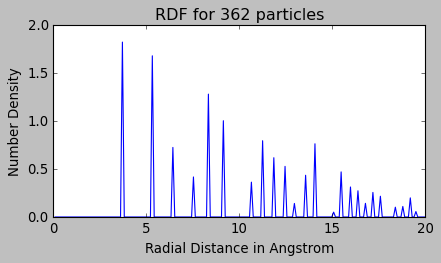

In [8]:
# case1: Number of particles = 362
a1 = initGrid( 362, 30, 30, 30);

# Create the RDF of the system.
write_xyz_traj(a1.transpose(), 362, root_p+r'\develop_box_362');

count  = 0;
xyzd = read_xyz_trj(root_p+r'\develop_box_362.xyz') 
#number of bins to use for rdf
    
nbins = 199
gr2 = np.zeros(nbins)
# box lenghts as a vector
L = np.array([30,30,30])
# limits to calculate the rdf
rdf_range = (0.10, 20.0)
# loop through frames
for key in xyzd.keys():
    r, temp = rdf(xyzd[key], L, nbins, rdf_range)
    gr2 += temp
    count +=1
        
    gr2 /= len(xyzd.keys());

# Print the RDF of the system   
plt.figure(figsize = (6,3))
plt.plot(np.linspace(0.1,20,199),gr2); 
plt.xlabel("Radial Distance in Angstrom")
plt.ylabel("Number Density")
plt.title("RDF for 362 particles")
plt.savefig('Initial_grid_gor.pdf', bbox_inches = 'tight')

## Simply use the verlet algorithm without any thermostat

In [9]:
# create the initial bunch of particles within the box
start = initGrid(362, 30, 30 ,30)

# Give them a push
iv = initvelocity(362,R, 150, 16.04)

# let them evolve and track the observables 
stat0 = verlet(362, 3.73, 148, 16.04, 30, 30, 30, 14, start, iv, 1e-15, 10000, 150);

C:\Users\tosam\AppData\Local\Temp/ipykernel_1540/77599481.py:572: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, steps)):


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 